## 단변량(Univariate) 시계열 예측과 외생 변수(Exogenous Variables)

이 노트북에서는 외생 변수를 사용한 모델링을 다룹니다. 튜토리얼의 진행방식은 아래의 목록 순서와 같습니다.

1. 시계열을 생성하는 과정에 대한 실질적인 통찰력을 얻기 위해 데이터셋에 대한 EDA를 수행합니다.
2. 벤치마킹을 위한 기본 모델 (외생 변수 없는 단변량 모델)을 구축합니다.
3. 가능한 최고의 성능을 확인하기 위해 모든 외생 변수를 가진 단변량 모델을 구축합니다.
4. 외생 변수가 있는 모델을 평가하고 잠재적인 문제점을 논의합니다.
5. 위에서 확인된 문제점을 해결합니다.
6. 최적의 모델로 미래 예측을 수행합니다.
7. 자동 시계열 모델링 (AutoML)로 작업 흐름을 복제합니다.


## ✔️ 모듈 로드 / 데이터셋

In [1]:
import os

# 오직 중요한 로깅만 활성화하기 (선택적)
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [2]:
# 설치된 라이브러리 확인
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.9.17 (main, Jul  5 2023, 15:35:09)  [Clang 14.0.6 ]
executable: /Users/teddy/miniconda/envs/pycaret3/bin/python
   machine: macOS-13.4.1-arm64-arm-64bit

PyCaret required dependencies:
                 pip: 23.1.2
          setuptools: 67.8.0
             pycaret: 3.0.4
             IPython: 8.14.0
          ipywidgets: 8.0.7
                tqdm: 4.65.0
               numpy: 1.23.5
              pandas: 1.5.3
              jinja2: 3.1.2
               scipy: 1.11.1
              joblib: 1.3.1
             sklearn: 1.2.2
                pyod: 1.1.0
            imblearn: 0.11.0
   category_encoders: 2.6.1
            lightgbm: 3.3.5
               numba: 0.57.1
            requests: 2.31.0
          matplotlib: 3.7.2
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.15.0
    plotly-resampler: Not installed
             kaleido: 0.2.1
           schemdraw: 0.15
         statsmodels: 0.14.0
              sktime: 0.20.0
               tbat

In [3]:
# 필요한 모듈 import
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment  # 시계열 데이터 예측 모듈

# 노트북을 위한 global fugure 설정
global_fig_settings = {
    # 'renderer': 'notebook',
    "renderer": "png",  # 'notebook' 으로 설정시 interactive 시각화 가능
    "width": 1000,
    "height": 600,
}

샘플 데이터셋을 로드 합니다. `pycaret` 내장 데이터셋을 불러오도록 하겠습니다.


In [4]:
# 데이터셋 로드
data = get_data("airquality")

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [5]:
# 데이터셋에서 Date 와 Time 을 병합하여 datetime 생성합니다
data.insert(0, "datetime", pd.to_datetime(data["Date"] + " " + data["Time"]))
data.drop(columns=["Date", "Time"], inplace=True)
data.head()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [6]:
# Target Y 정의
target = "CO(GT)"

**이 데이터셋에는 -200으로 태그된 결측값이 있습니다. [참고](https://archive.ics.uci.edu/ml/datasets/air+quality). 이 값들을 제거해야합니다(그것들을 NaN으로 대체하십시오) 및 `pycaret`이 적절하게 대치를 처리하게 하십시오(훈련 중 데이터 유출 방지).`


In [7]:
# -200 데이터 조회
data[data[target] == -200].head()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
10,2004-03-11 04:00:00,-200.0,1011,14,1.3,527,21,1818,34,1197,445,10.1,60.5,0.7465
34,2004-03-12 04:00:00,-200.0,831,10,1.1,506,21,1893,32,1134,384,6.1,65.9,0.6248
39,2004-03-12 09:00:00,-200.0,1545,-200,22.1,1353,-200,767,-200,2058,1588,9.2,56.2,0.6561
58,2004-03-13 04:00:00,-200.0,1147,56,6.2,821,109,1132,83,1412,992,7.0,71.1,0.7158
82,2004-03-14 04:00:00,-200.0,1130,56,5.2,773,70,1130,82,1452,1051,12.1,61.1,0.8603


In [8]:
# -200 데이터 처리 후 결과 확인
data.replace(-200, np.nan, inplace=True)
data[data[target] == -200]

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


이제, 우리의 EDA와 모델링으로 넘어가 봅시다.


## 👀 탐색적 분석(Exploratory Data Analysis)


In [9]:
# EDA 실험 만들기
eda = TSForecastingExperiment()

In [10]:
# 5개 행 조회
data.head()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


### `setup()`

- 링크: https://pycaret.readthedocs.io/en/latest/api/time_series.html#pycaret.time_series.setup


**`numeric_imputation_target` / `numeric_imputation_Exogenous` 결측치 처리 방법**

- `'drift'` : drift/트렌드 값은 sktime.PolynomialTrendForecaster(degree=1)에 의해 계산됩니다. 먼저, transform()의 X는 ffill로 채워진 후 bfill로 채워집니다. 그 후 PolynomialTrendForecaster(degree=1)가 채워진 X에 맞춰져(fitted) 결측치가 있던 인덱스에서 예측 값이 조회됩니다.
- `'linear'` : 선형 보간, pd.Series.interpolate() 사용. 이 방법은 외삽(extrapolation)할 수 없으므로, 항상 transform()에 제공된 데이터에 맞춰집니다.
- `'nearest'` : 가장 가까운 값을 사용, pd.Series.interpolate() 사용.
- `'constant'` : 모든 NaN에 대해 같은 상수 값 (인수 value에서 주어짐).
- `'mean'` : fit 데이터의 pd.Series.mean().
- `'median'` : fit 데이터의 pd.Series.median().
- `'backfill' or 'bfill'` : pd.Series.fillna()에서 적용.
- `'pad' or 'ffill'` : pd.Series.fillna()에서 적용.
- `'random'` : fit 데이터의 pd.Series.min()과 .max() 사이의 랜덤 값. 만약 pd.Series의 dtype이 int라면, 샘플은 균등 이산(uniform discrete)입니다. 만약 pd.Series의 dtype이 float라면, 샘플은 균등 연속(uniform continuous)입니다.


In [11]:
# Setup 함수에서 데이터 전처리에 대한 설정을 지정합니다.
_ = eda.setup(
    data=data,  # 데이터프레임 전달
    target=target,  # 예측 컬럼
    index="datetime",  # Time 컬럼
    # Forecast Horizon: 예측할 미래 기간을 입력합니다.
    fh=48,
    # 'drift', 'linear', 'nearest', 'mean', 'median', 'backfill', 'bfill', 'pad', 'ffill', 'random'
    numeric_imputation_target="drift",
    # 'drift', 'linear', 'nearest', 'mean', 'median', 'backfill', 'bfill', 'pad', 'ffill', 'random'
    numeric_imputation_exogenous="drift",
    fig_kwargs=global_fig_settings,  # 플롯에 대한 기본 설정을 지정합니다
    session_id=42,
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(9357, 13)"
5,Transformed data shape,"(9357, 13)"
6,Transformed train set shape,"(9309, 13)"
7,Transformed test set shape,"(48, 13)"
8,Rows with missing values,91.2%
9,Fold Generator,ExpandingWindowSplitter


진행하기에 앞서, 여기에서 몇 가지 유용한 정보를 관찰할 수 있습니다.

1. 데이터는 시간당 데이터셋이므로, 24시간 주기가 테스트되었습니다. 이 시간 주기에서 계절성이 감지되었습니다.
2. 데이터의 성격 때문에 모델링하면서 데이터를 차분하는 것이 권장됩니다(d=1). 우리는 이를 EDA 과정에서 더 평가해 볼 것입니다.


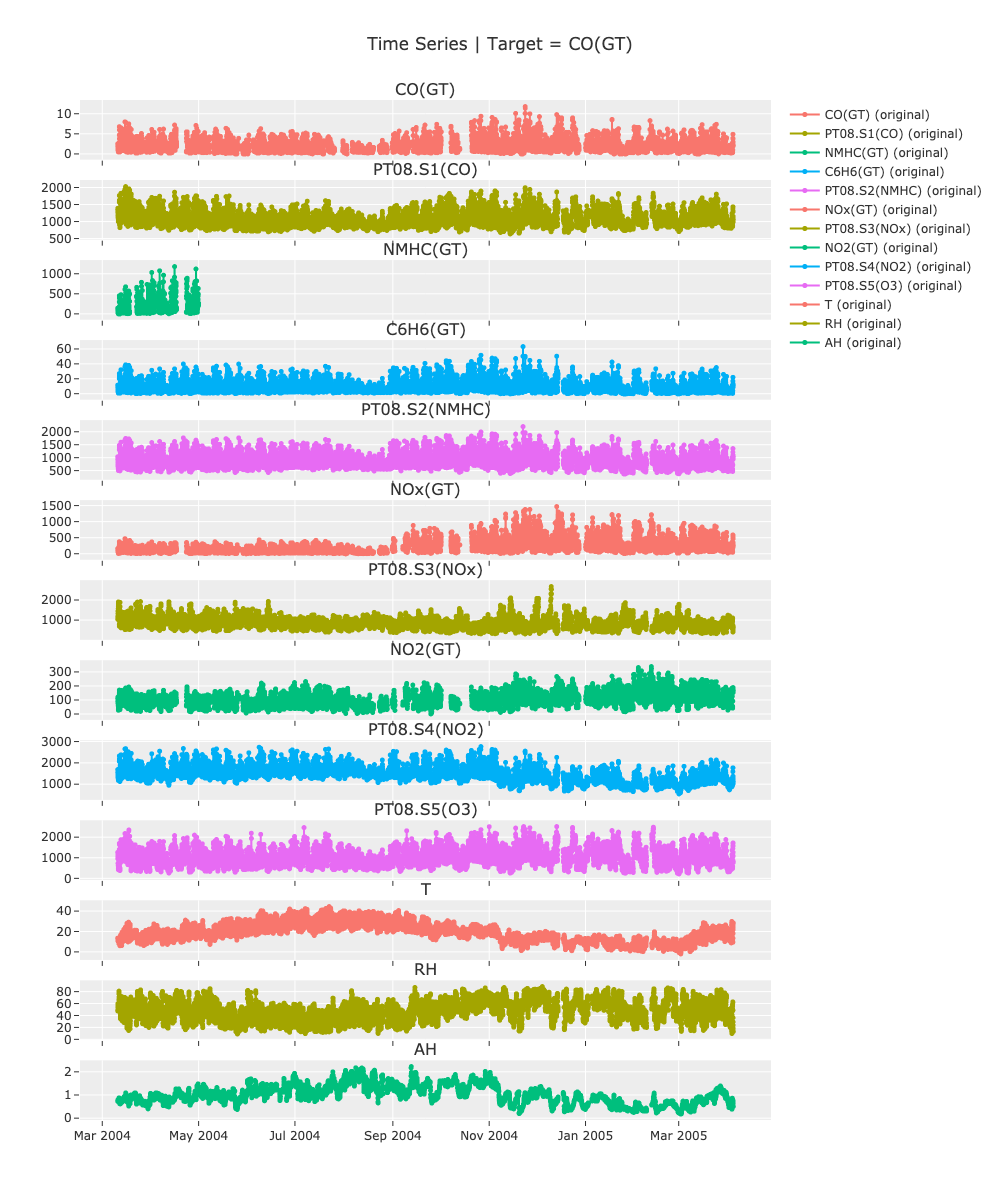

In [12]:
# 시계열 데이터 시각화
eda.plot_model(
    fig_kwargs={
        "renderer": "png",  # 'notebook' 으로 설정시 interactive 플롯을 생성합니다.
        "width": 1000,
        "height": 1200,
    }
)

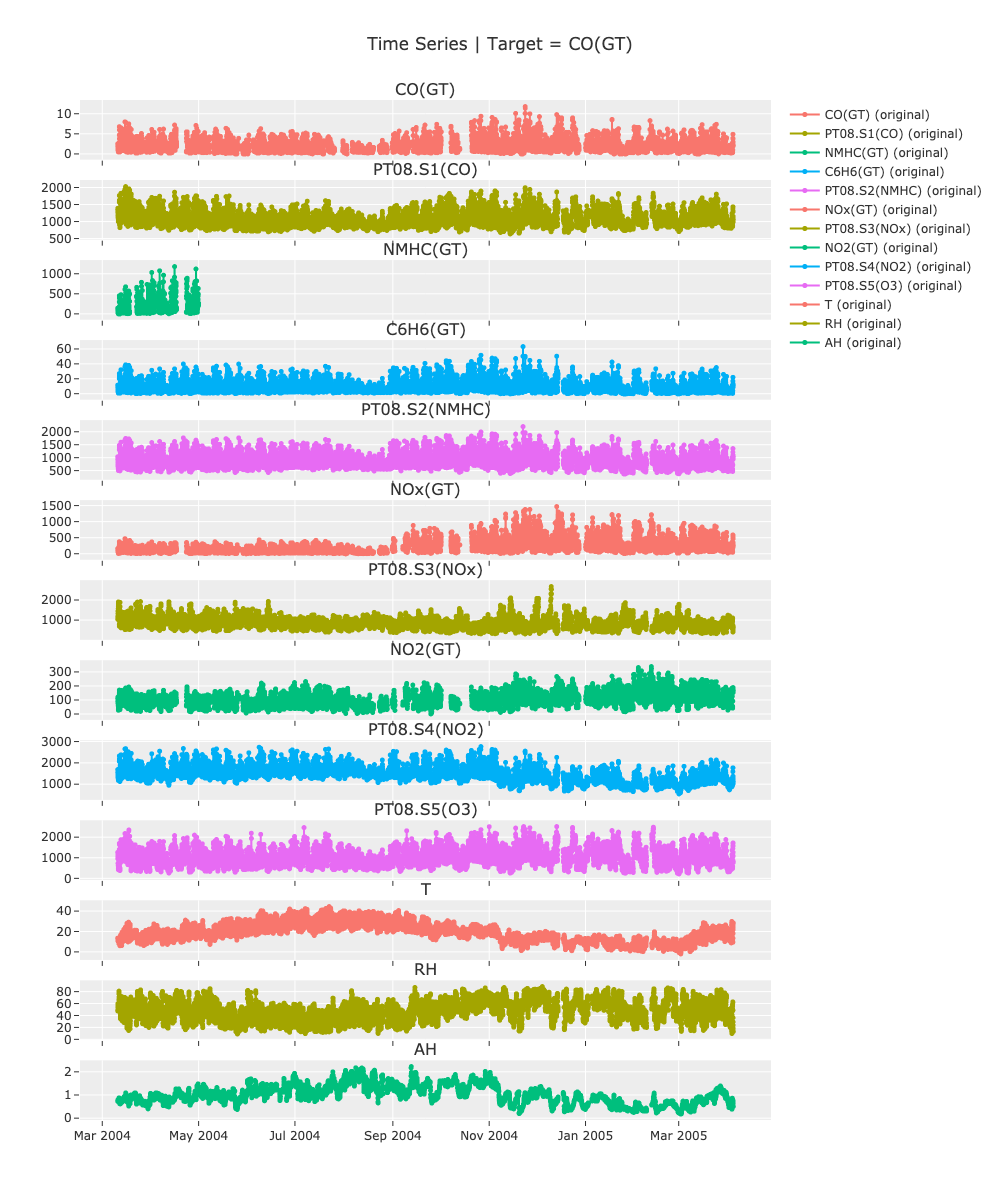

In [13]:
# 시계열 데이터 시각화 with 세부설정
eda.plot_model(
    plot="ts",
    fig_kwargs={
        "height": 1200,
        # resampler_kwargs를 사용하여, plotly-resampler 객체의 생성자를 구성할 수 있습니다.
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            # show_dash kwargs는 show_dash (render) 메서드의 kwargs를 보류합니다.
            "show_dash": {"mode": "inline", "port": 8055},
        },
    },
    # display_format='plotly-dash', # interactive 시각화 출력을 원한다면 주석을 해제 합니다.
    # display_format="plotly-widget",  # interactive 시각화 출력을 원한다면 주석을 해제 합니다.
)

확대 축소된 그래프에서 세부 사항을 보기 힘들 수도 있지만, pycaret는 인터랙티브 plotly 플롯을 사용하여 확대하는 기능을 제공합니다. 확대하면, **대략 19:00와 8:00에 피크가 있는 명확한 24시간 주기** 를 확인할 수 있습니다.

또한 `NMHC(GT)`는 모든 값이 누락된 것으로 보입니다. 우리는 차후에 개발할 다변량 모델에서 이 변수를 제거할 예정입니다.

다음으로, 설정에서는 데이터를 차분하는 것이 좋다고 권장하였습니다. 이것이 어떻게 보이는지, 그리고 필요한지 살펴보겠습니다. 차분된 데이터 외에도, 우리는 ACF, PACF 그리고 Periodogram 과 같은 일부 진단을 그려보겠습니다.

Periodogram 은 시계열에서 스펙트럼 밀도를 주파수 함수로 그리는 그래프입니다. 이 경우, 주파수는 0에서 0.5까지의 범위를 가집니다(주파수를 측정하는데 필요한 최소 점은 2개로, 이는 최대 주파수 0.5에 해당합니다). 여러 주파수에서의 크기는 시계열에 대한 중요한 특성을 파악하는 데 사용될 수 있습니다. 이에 대해서는 아래에서 살펴보겠습니다.


In [14]:
# 결측치가 많아 제거합니다.
exclude = ["NMHC(GT)"]

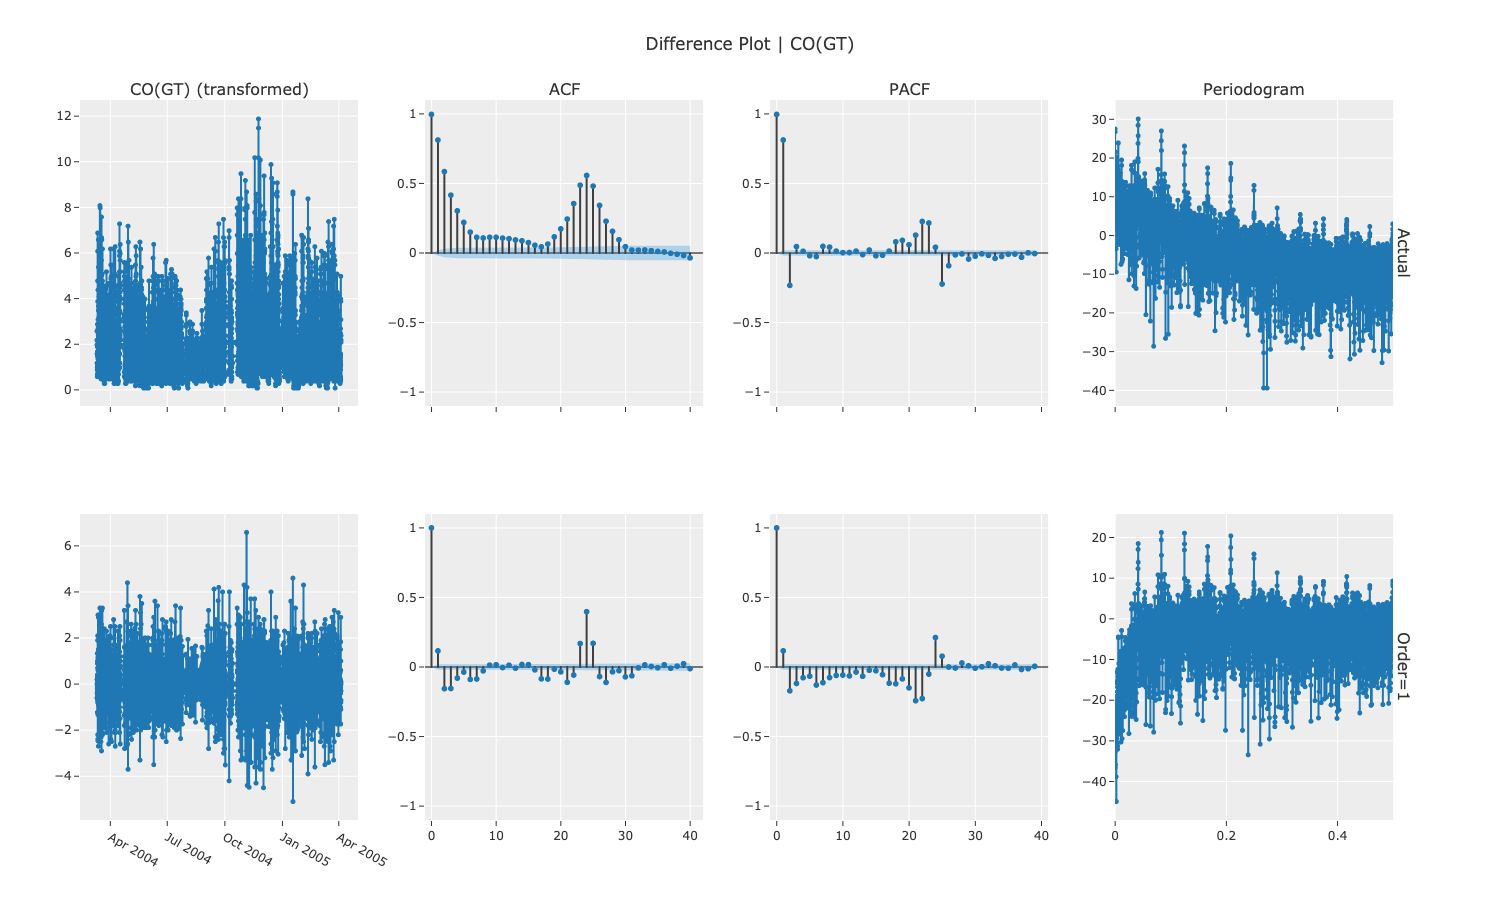

In [15]:
# 기본적으로 원본 데이터를 첫 번째 차분(order d = 1)과 함께 그래프로 그립니다.
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "width": 1500,
        "height": 900,
        # plotly-widget을 사용할 때는 show_dash kwargs를 전달할 필요가 없습니다.
        "resampler_kwargs": {"default_n_shown_samples": 1500},
    },
    data_kwargs={"acf": True, "pacf": True, "periodogram": True},
    # display_format='plotly-dash', # interactive 시각화 출력을 원한다면 주석을 해제 합니다.
    # display_format='plotly-widget', # interactive 시각화 출력을 원한다면 주석을 해제 합니다.
)

위의 그래프들은 몇 가지 흥미로운 특성을 보여줍니다.

**원본 데이터**

1. 차분이 필요한가요?

- 데이터셋은 상당히 높은 유의 수준을 보여주는 확장된 자기상관성(ACF - row 1, col 2)을 보여줍니다. 이는 차분이 필요하다는 것을 나타냅니다.
- 같은 관측 결과는 PACF 플롯을 보면서도 파악할 수 있습니다. (row 1, col 3) 이는 lag1에서 매우 높은 상관관계를 보여줍니다. (즉, 이전 시점)
- 이 특성은 주기도표 (row 1, col 4)에서도 확인할 수 있습니다. 이는 `~f = 0` 에서 피크를 보여줍니다. `~f = 0` 에서 피크가 나타나는 것은 시간 주기가 매우 크다는 것을 의미하며, 이는 '랜덤 워크' 유형의 행동을 차분으로 모델링할 수 있다는 것을 시사합니다.)

[참고]

- **피리오도그램 (Periodogram)**

피리오도그램은 시계열 데이터의 주파수 도메인 특성을 분석하는 데 사용되는 일종의 플롯이며, 주로 시계열 데이터의 스펙트럼 분석에 사용됩니다. 이는 시계열의 주기성을 이해하는 데 도움이 되며, 시간 도메인에서는 눈으로 보이지 않는 특성을 빛으로 드러내줍니다.

피리오도그램은 시계열의 파워 스펙트럼 밀도 (Power Spectrum Density, PSD)를 추정합니다. PSD는 시계열에서 각 주파수 성분의 '강도'를 나타냅니다. 높은 PSD 값을 가진 주파수는 해당 시계열에 더 강한 주기적 특성을 나타냅니다.

- **~f = 0 의 의미**

피리오도그램에서의 `~f = 0` 은 주파수가 0인 지점, 즉 시계열 데이터의 DC 성분(직류 성분)을 의미합니다. 시계열 데이터의 평균값을 나타내며, 이는 시계열 데이터의 전반적인 수준 혹은 추세를 의미합니다.

예를 들어, 신호에 DC 성분이 있다는 것은 해당 신호가 0을 중심으로 진동하지 않고, 어떤 양의 값 혹은 음의 값으로 이동한 상태를 나타냅니다. 이는 신호의 전반적인 '수준' 혹은 '오프셋'을 나타내는 값이라고 할 수 있습니다.

따라서, 주파수가 0인 곳에서의 값은 주파수 성분이 없이 단순히 상수 값으로 이루어진 신호 성분을 나타냅니다. 이런 성분은 종종 시계열 데이터의 '백그라운드 노이즈'나 '기본 수준' 등을 나타내는 데 사용됩니다.

[예시]

- **피리오도그램 (Periodogram)** 에 대해 생각해보면, 음악에 사용되는 그래픽 이퀄라이저를 떠올릴 수 있습니다. 이퀄라이저는 음악의 다양한 주파수 성분을 분석해서 그 강도를 시각적으로 보여주죠. 예를 들어, 베이스 사운드(저주파)가 강하면 그 부분의 미터가 더 높게 표시되고, 트레블 사운드(고주파)가 약하면 그 부분의 미터가 낮게 표시됩니다. 이것이 바로 피리오도그램이 시계열 데이터에 대해 하는 일입니다. 주기적인 패턴이 강하게 나타나는 주파수를 보여줍니다.

- `~f = 0` 의 의미에 대해서는, 라디오의 볼륨 조절을 생각해보면 좋습니다. 라디오의 볼륨을 조절하면 모든 음악, 즉 모든 주파수 성분의 강도가 일괄적으로 증가하거나 감소합니다. 이것은 피리오도그램에서 ~f = 0, 즉 주파수가 0인 지점에서의 값을 조절하는 것과 유사합니다. 주파수가 0인 성분은 시계열 데이터의 전반적인 '볼륨' 또는 '수준'을 조절하는 역할을 합니다. 따라서, 이 값을 높이면 시계열 데이터 전체의 강도가 증가하고, 낮추면 감소하게 됩니다. 이것이 바로 ~f = 0의 의미입니다.

---

2. 계절성을 모델링해야 할까요?

- ACF는 또한 lag 24에서 피크를 나타내어 24의 계절성을 보여줍니다. (이것은 설정 단계에서도 확인할 수 있었습니다)
- 이는 주기도표에서도 확인할 수 있습니다. (기본 f = 0.0417에서 피크를 보여주며, 그것의 고유 주파수는 0.0834, 0.1249, ...). f = 0.0417는 T = 1/0.0417 = 24, 즉 24시간의 계절 주기를 나타냅니다.

**차분 순서 = 1**

1. 차분 순서 = 1은 확장된 자기상관성의 많은 부분이 처리되었음을 보여줍니다. (row 2, col 2의 크기가 이전보다 훨씬 작습니다.) 이는 주기도표 (row 2, col 4)에서도 확인할 수 있습니다. 여기서 ~ f = 0에서의 크기가 이전보다 훨씬 작습니다.
2. ACF는 여전히 lag = 24에서 피크를 보여주며, 주기도표도 이를 나타냅니다. 이는 우리가 이를 적절히 모델링하기 위해 여전히 처리해야 함을 나타냅니다. 다음으로 계절성을 포함한 차분을 플로팅함으로써 이를 처리해봅시다. 이번에는 분석에 더 세밀한 제어를 원하기 때문에 lag들을 명확히 지정하겠습니다.

참고: lag = 1은 차분 순서 = 1, 즉 첫 번째 차분을 의미하며, lag = [1, 24]는 첫 번째 차분이 취해진 다음 계절 차분 24가 취해진다는 것을 의미합니다.


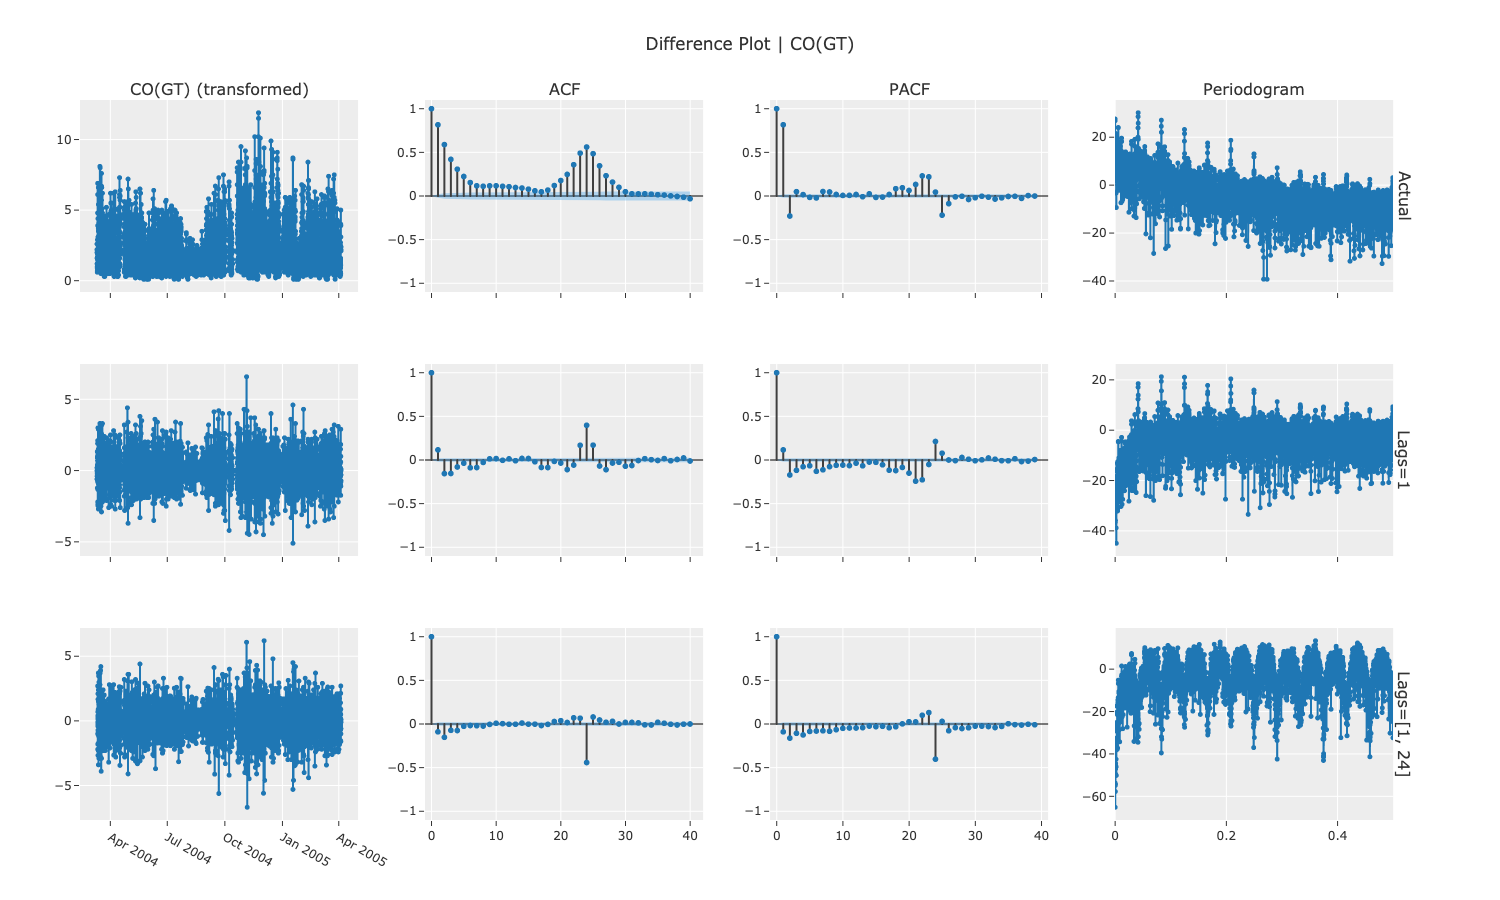

In [16]:
# 차분에 대한 시각화
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "width": 1500,
        "height": 900,
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            "show_dash": {"mode": "inline", "port": 8056},
        },
    },
    data_kwargs={
        "lags_list": [1, [1, 24]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    # display_format='plotly-dash',    # interactive 시각화 출력을 원한다면 주석을 해제 합니다.
    # display_format="plotly-widget",  # interactive 시각화 출력을 원한다면 주석을 해제 합니다.
)

우리는 마지막 플롯의 반복이 되는 첫 번째와 두 번째 행보다는 3번째 행에 주목할 것입니다. 3번째 행은 24의 계절 차분이 뒤따르는 1차 차분을 표현합니다. ACF(행 3, 열 2)에서 볼 수 있듯이, 모든 확장 자기상관이 처리되었습니다. 우리는 여전히 lag = 24에서 피크를 보지만(이제는 음수), 페리오도그램을 주의 깊게 검토하면, 누출이 매우 낮은 스펙트럼 밀도를 가지고 있다는 것을 알 수 있습니다. 따라서, 첫 번째 차분과 24의 계절 차분을 취하면 이 시계열을 상당히 합리적으로 모델링할 수 있다는 결론을 내릴 수 있습니다. 그러나,

참고: 독자는 이것을 더욱 조사하여 AR 및 MA 구성 요소를 알아낼 수 있습니다. 예를 들어, PACF 플롯(행 3, 열 3)은 lag = 2에서 그리고 그 이후에서 음의 스파이크(중요)를 보여줌으로써 적어도 2차 AR 구성 요소를 나타냅니다. 단순성을 위해 이번 연습에서는 그것을 사용하지 않겠지만, 더 완전한 평가를 위해 반드시 탐색해야 합니다.

다음으로, 외생 변수가 타겟에 미치는 영향과 그 사이의 상관 관계를 조사해 보겠습니다. 이는 Cross Correlation Plots을 이용하여 달성할 수 있습니다.


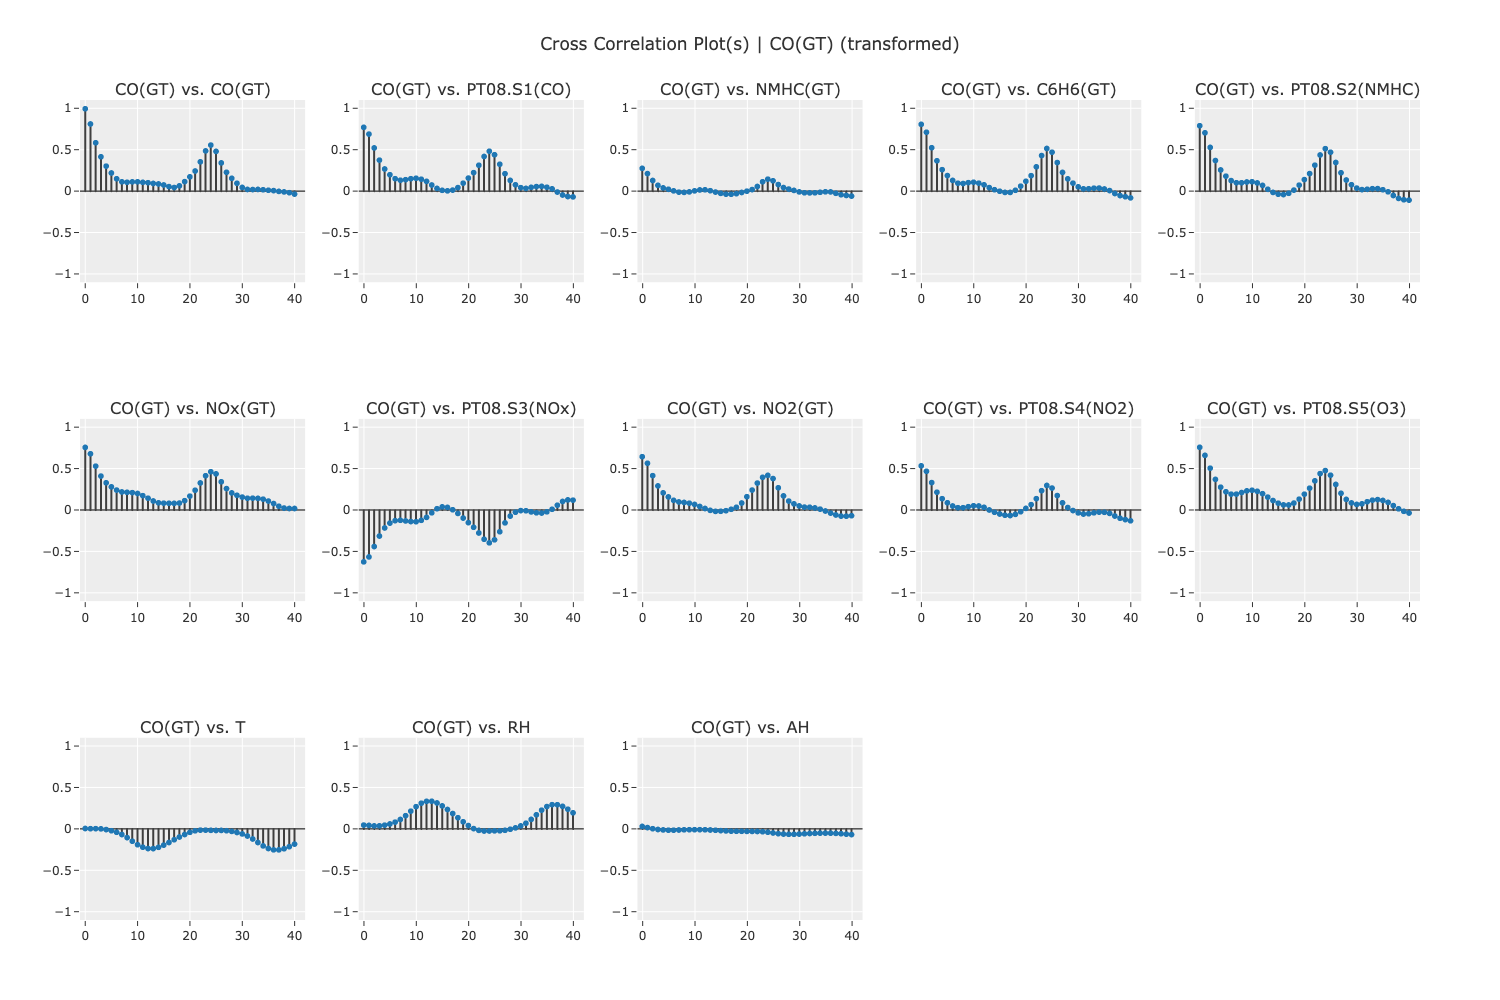

In [17]:
# Cross Correlation Plot 시각화
eda.plot_model(plot="ccf", fig_kwargs={"height": 1000, "width": 1500})

첫 번째 플롯(행 1, 열 1)은 타겟의 자기상관성을 보여주며(ACF와 같음), 나머지 플롯들은 타겟과 외생 변수의 지연된 값들 사이의 상관성을 보여줍니다. 예를 들어, 행 1, 열 2는 CO 농도가 lag 0과 lag 24에서 `PT08.S1(CO)`와 매우 상관관계가 있음을 보여줍니다. `NOx(GT)`, `C6H6(GT)`, `PT08.S2(NMHC)` 등 다른 변수들에서도 비슷한 패턴을 볼 수 있습니다. 이 변수들은 CO 농도를 모델링할 때 유용할 수 있습니다.

또 하나의 관찰 결과로, 절대 습도 `AH`는 CO 농도와 매우 강한 상관관계를 보이지 않는 것으로 보입니다. 이 변수는 모델링에 중요하지 않을 수 있습니다.


In [18]:
# AH 컬럼 제외목록에 추가
exclude.append("AH")
exclude

['NMHC(GT)', 'AH']

이제 모델링 단계로 넘어가 보겠습니다.


In [19]:
exclude = ["NMHC(GT)", "AH"]
data.drop(columns=exclude, inplace=True)
data.head()

,datetime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH
0,2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9
1,2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7
2,2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0
3,2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0
4,2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6


## 🔆 (베이스라인) 외생 변수 없이 단일 변수 예측하기


In [20]:
# 시계열 실험(Experiment) 객체를 생성합니다.
exp_uni = TSForecastingExperiment()

# 설정 값 지정
exp_uni.setup(
    data=data[target],
    fh=48,  # (예측 time-step) forecast horizon 설정
    numeric_imputation_target="linear",
    numeric_imputation_exogenous="linear",
    fig_kwargs=global_fig_settings,
    session_id=42,
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(9357, 1)"
5,Transformed data shape,"(9357, 1)"
6,Transformed train set shape,"(9309, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,18.0%
9,Fold Generator,ExpandingWindowSplitter


In [21]:
# 'arima' 모델을 생성합니다.
model = exp_uni.create_model(
    "arima",  # ARIMA, SARIMA, SARIMAX 등을 커버. 모두 동일하게 arima 로 지정
    order=(0, 1, 0),  # (p, d, q)
    seasonal_order=(0, 1, 0, 24),  # (p, d, q, s)
)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,9164.0000,1.1705,1.1515,1.0340,1.4835,0.5751,0.9044,-1.3625
1,9212.0000,2.1365,1.6565,1.8839,2.1316,1.5146,0.7456,-2.8068
2,9260.0000,1.0963,0.8704,0.9652,1.1183,1.1796,1.2402,-5.1529
Mean,nan,1.4677,1.2261,1.2944,1.5778,1.0898,0.9634,-3.1074
SD,nan,0.4738,0.3252,0.4178,0.4190,0.3888,0.2062,1.5620


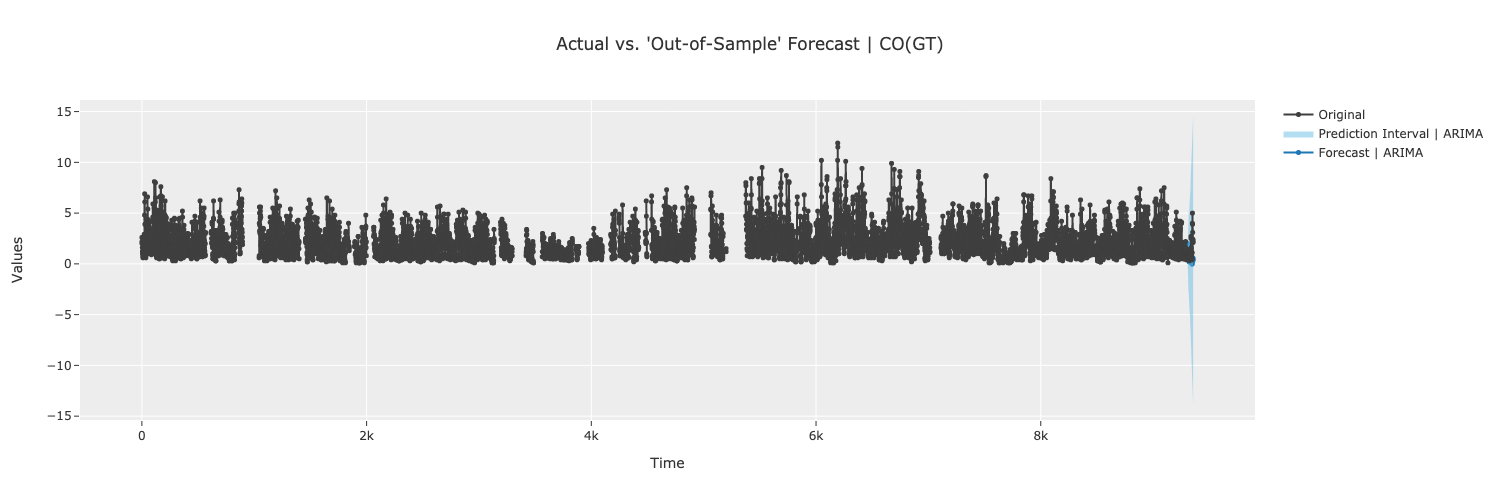

In [22]:
exp_uni.plot_model(
    model,
    fig_kwargs={
        # 'notebook' 으로 설정시 interactive 플롯을 생성합니다.
        "renderer": "png",
        "width": 1500,
        "height": 500,
    },
)

예측을 확대해 보면, 모델이 데이터셋의 일부 추세(피크)를 포착할 수 있는 것을 알 수 있지만, 모든 것을 포착하지는 못합니다. 베이스라인 모델의 성능은 CV 폴드 전체의 평균 MASE가 1.46 라는 것을 보여주며, 이는 그다지 좋지 않은 성과입니다.

**1보다 큰 값은 모델이 단순한 1단계 예측조차도 못 따라가고 있다는 것을 의미**합니다. 이 모델은 더 개선이 필요합니다. 외생 변수를 추가하여 모델 성능을 향상시킬 수 있는지 살펴보겠습니다.


## 🔆 (개선된 모델) 외생 변수를 사용한 단일 변수 예측하기


In [23]:
# 외생변수를 추가한 실험 생성
exp_exo = TSForecastingExperiment()

# setup 시 외생변수를 포함한 dataframe 을 입력
exp_exo.setup(
    data=data,
    target=target,
    index="datetime",
    fh=48,
    numeric_imputation_target="linear",
    numeric_imputation_exogenous="drift",
    fig_kwargs=global_fig_settings,
    session_id=42,
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(9357, 11)"
5,Transformed data shape,"(9357, 11)"
6,Transformed train set shape,"(9309, 11)"
7,Transformed test set shape,"(48, 11)"
8,Rows with missing values,25.8%
9,Fold Generator,ExpandingWindowSplitter


In [24]:
# SARIMAX 모델 생성
model_exo = exp_exo.create_model(
    "arima",
    order=(0, 1, 0),
    seasonal_order=(0, 1, 0, 24),
)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2005-03-27 14:00,0.2063,0.1858,0.1822,0.2394,0.1056,0.1138,0.9385
1,2005-03-29 14:00,0.1907,0.1667,0.1681,0.2145,0.1019,0.0966,0.9615
2,2005-03-31 14:00,0.3687,0.2967,0.3246,0.3813,0.3682,0.4894,0.2849
Mean,NaT,0.2552,0.2164,0.2250,0.2784,0.1919,0.2333,0.7283
SD,NaT,0.0805,0.0573,0.0707,0.0735,0.1246,0.1813,0.3137


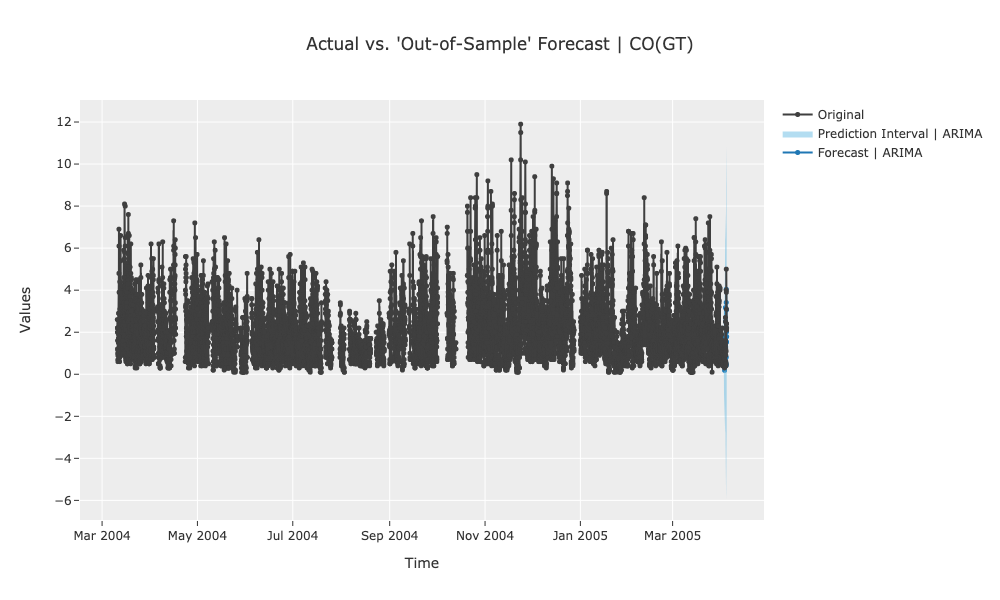

In [25]:
# Actual vs Prediction 시각화
exp_exo.plot_model(model_exo)

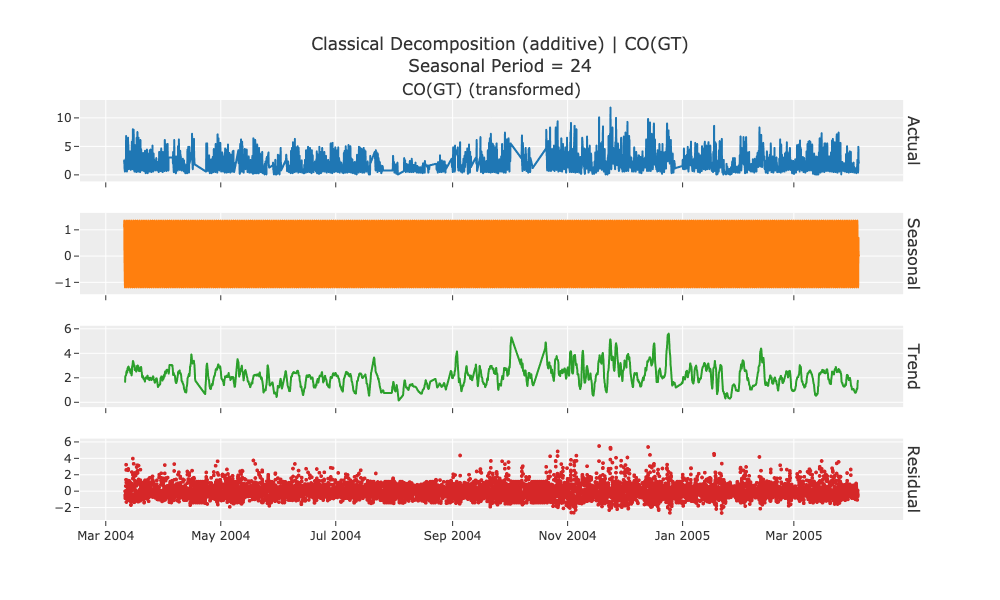

In [26]:
# 시계열 Decomposition - seasonal period
exp_exo.plot_model(plot="decomp", data_kwargs={"seasonal_period": 24})

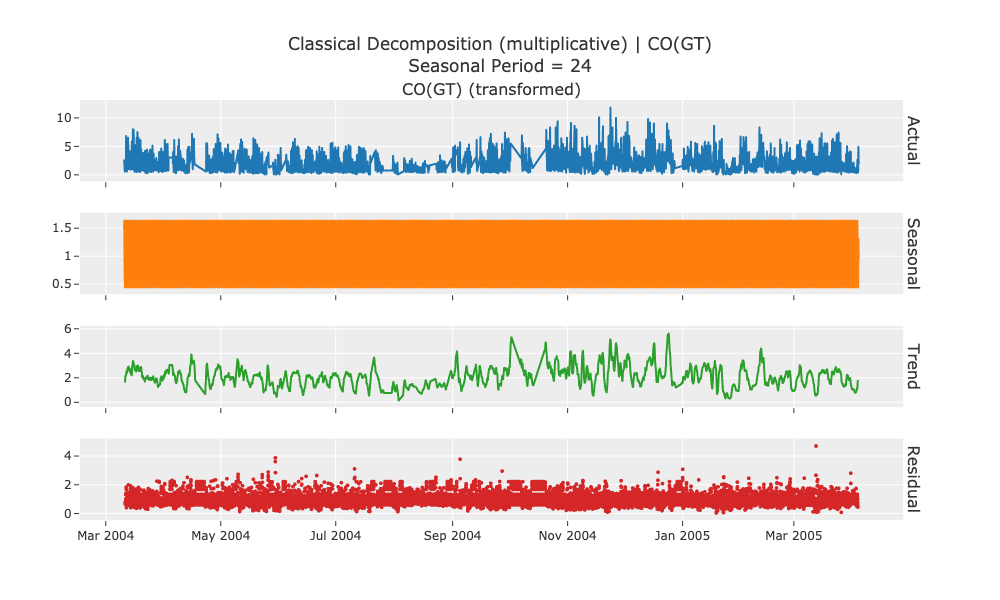

In [27]:
# 시계열 Decomposition
exp_exo.plot_model(plot="decomp", data_kwargs={"type": "multiplicative"})

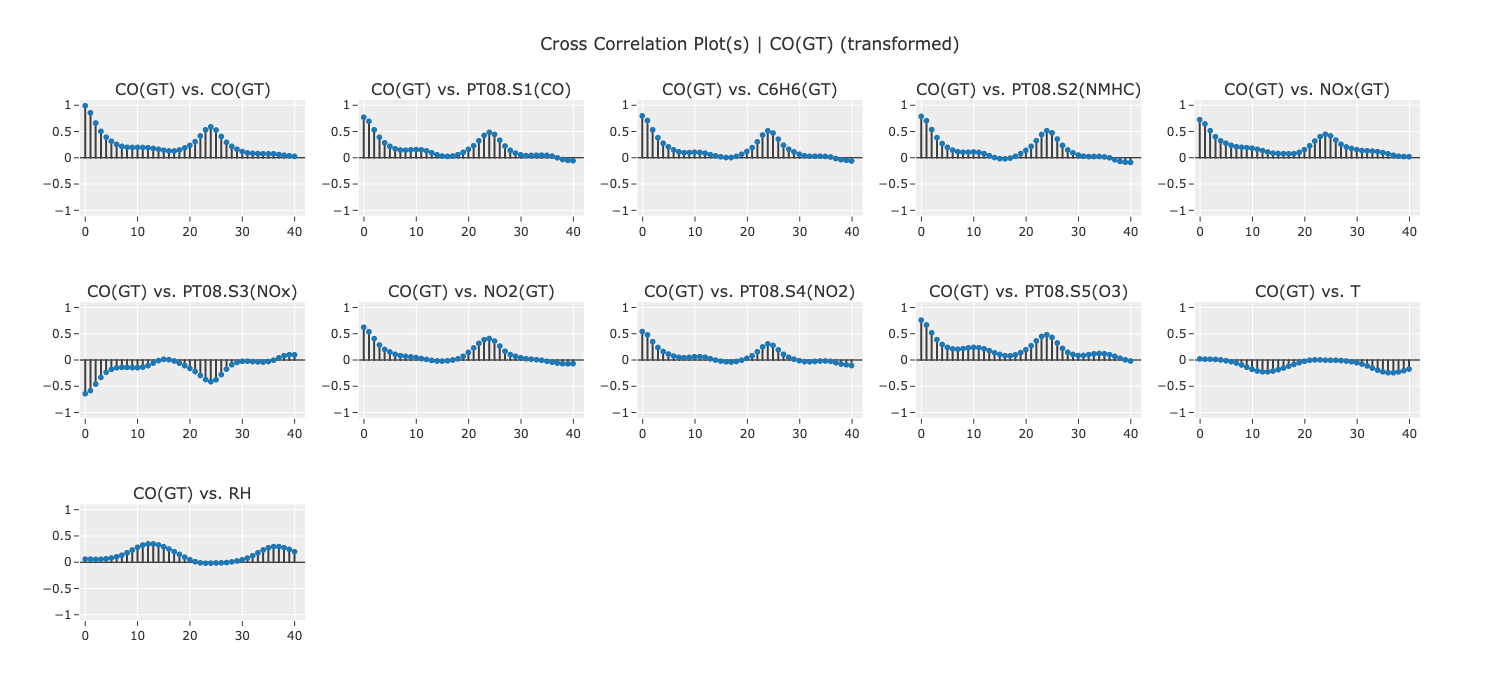

In [28]:
# Cross Correlation Plot 시각화
exp_exo.plot_model(
    plot="ccf",
    fig_kwargs={
        "width": 1500,
        "height": 700,
    },
)

## ❗️ 모델 평가하기


나쁘지 않습니다. `MASE` 를 상당히 향상시키는 데 성공했으며, 이는 단변량 모델보다 훨씬 좋고, 단순 모델에 비해 큰 개선입니다. 이 개선에 만족해야 합니다.

모델을 최종화하기 위해 전체 데이터셋에 대해 훈련시키고, 실제 미래 예측을 할 수 있도록 하겠습니다.


In [29]:
# Finalize Model : 전체 데이터를 활용한 재학습
final_model_exo = exp_exo.finalize_model(model_exo)

In [30]:
# 예측을 위한 wrapper 함수
def safe_predict(exp, model):
    try:
        exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        # 외생변수(Exogenous Variable) 가 설정이 안되었기 때문에 에러 발생
        print(
            f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}"
        )


safe_predict(exp_exo, final_model_exo)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
10 exogenous variables (X) needed in order to make future predictions:
['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH']


이 접근 방식은 부작용이 없지 않습니다. 문제는 우리가 10개의 외생 변수를 가지고 있다는 것입니다. 따라서 CO 농도의 알려지지 않은 미래 값을 얻으려면, 이러한 외생 변수들의 미래 값을 얻어야 합니다. 이는 일반적으로 일부 예측 과정을 통해 얻어집니다. 하지만 각 예측에는 오차가 있으며, 특히 외생 변수가 많을 때 이러한 오차는 복리로 증폭될 수 있습니다.

**예측 성능을 저하시키지 않으면서 이 외생 변수들을 유용한 소수의 변수로 줄일 수 있는지 살펴보겠습니다.**


## 🔆 (간소한 모델) 제한적인 외생 변수를 사용한 단일 변수 예측

CCF 분석에서 우리는 많은 외생 변수들이 CO 농도와 매우 유사한 상관 구조를 보인다는 것을 발견했습니다. 예를 들어, 24시간 전(`lag = 24`)의 `PT08.S1(CO)`, `NOx(GT)`, `C6H6(GT)`, `PT08.S2(NMHC)` 값은 CO 농도와 높은 양의 상관 관계를 보입니다. 이들 중에서도 `NOx(GT)`가 lag 24에서 가장 높은 양의 상관 관계를 가지는 변수입니다.

마찬가지로, 24시간 전(`lag = 24`)의 `PT08.S3(NOx)` 값은 CO 농도와 가장 높은 음의 상관 관계를 보입니다. 우리는 이 변수를 유지하기로 결정했습니다.

마지막으로, 일일 사이클에서 12시간 전에 발생한 사건도 현재 값을 영향을 줄 수 있습니다(예: 지난 밤의 값은 다음 날에 영향을 줄 수 있고 그 반대도 가능합니다). Lag = 12에서 CO 농도와 가장 높은 상관 관계를 가지는 변수는 `RH`입니다. 이 변수도 유지하기로 결정했습니다.


In [31]:
# 시계열 실험 생성
exp_slim = TSForecastingExperiment()

# 사용할 외생변수 & 타겟 정의
keep = [target, "datetime", "NOx(GT)", "PT08.S3(NOx)", "RH"]
data_slim = data[keep]

# setup
exp_slim.setup(
    data=data_slim,
    target=target,
    index="datetime",
    fh=48,
    numeric_imputation_target="drift",
    numeric_imputation_exogenous="linear",
    fig_kwargs=global_fig_settings,
    session_id=42,
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(9357, 4)"
5,Transformed data shape,"(9357, 4)"
6,Transformed train set shape,"(9309, 4)"
7,Transformed test set shape,"(48, 4)"
8,Rows with missing values,25.8%
9,Fold Generator,ExpandingWindowSplitter


In [32]:
# 동일한 SARIMAX 모델을 생성
model_slim = exp_slim.create_model(
    "arima", order=(0, 1, 0), seasonal_order=(0, 1, 0, 24)
)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2005-03-27 14:00,0.2425,0.2653,0.2001,0.3286,0.1305,0.1299,0.8808
1,2005-03-29 14:00,0.3796,0.3707,0.3128,0.4587,0.3020,0.2191,0.8237
2,2005-03-31 14:00,0.3069,0.3331,0.2526,0.4117,0.2805,0.3921,0.2508
Mean,NaT,0.3096,0.3231,0.2552,0.3997,0.2377,0.2470,0.6518
SD,NaT,0.0560,0.0436,0.0460,0.0538,0.0763,0.1089,0.2845


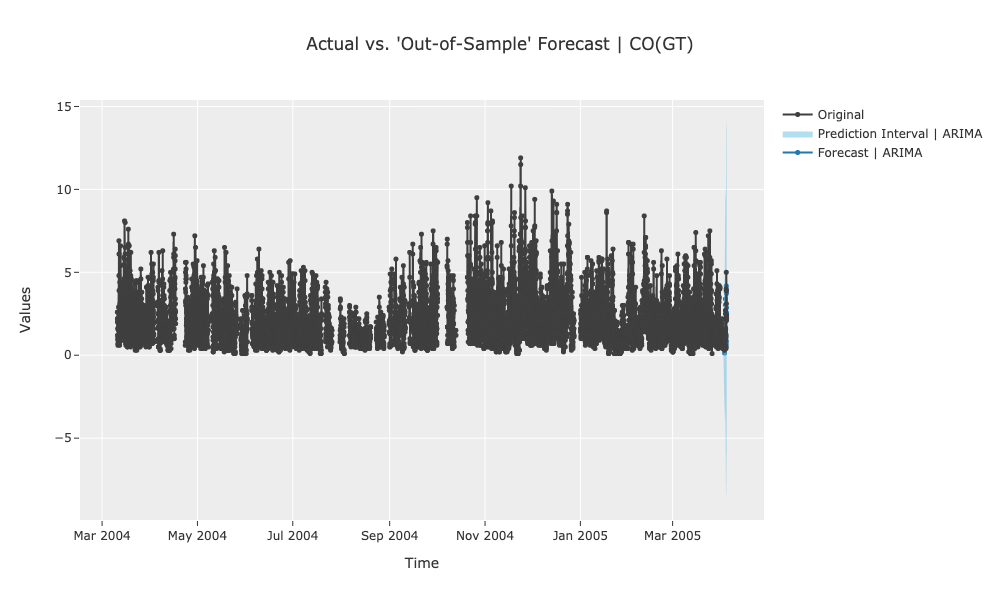

In [33]:
# 시각화
exp_slim.plot_model(
    model_slim,
)

나쁘지 않습니다. MASE는 약간 증가했지만, 우리는 외생 변수를 크게 줄일 수 있었습니다. 이것은 우리가 '진짜' 알려지지 않은 미래 예측을 할 때 도움이 될 것입니다. 왜냐하면 CO 농도에 대한 예측을 하기 위해 이러한 외생 변수의 '알려지지 않은' 미래 값이 필요하기 때문입니다.


##  🌈 모델 최종화(Finalize) 하기

- 실제 미래 예측을 할 수 있도록 슬림 모델을 전체 데이터셋에 대해 훈련시킵니다.
- 배포를 위해 모델을 pickle 파일로 저장합니다.


In [34]:
# 전체 데이터셋으로 재학습
final_slim_model = exp_slim.finalize_model(model_slim)

In [35]:
# 모델 저장 (모델, 저장할 모델명)
_ = exp_slim.save_model(final_slim_model, "final_slim_model")

Transformation Pipeline and Model Successfully Saved


In [36]:
# 여전히 외생변수가 누락되었기 때문에 에러 발생
safe_predict(exp_slim, final_slim_model)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
3 exogenous variables (X) needed in order to make future predictions:
['NOx(GT)', 'PT08.S3(NOx)', 'RH']


**따라서 우리는 여전히 3개의 외생 변수에 대한 미래 값을 필요로 합니다. 다음 파트에서 예측 기법을 사용하여 이를 얻을 것입니다.**


## 🔥 외생변수(Exogenous Features) 에 대한 값 얻기


이제 우리의 모델을 구축했으니, 미래 예측을 진행해 보겠습니다.


In [37]:
# 사용할 외생변수 정의(데모를 위해 3개만 추려냅니다)
exog_vars = ["NOx(GT)", "PT08.S3(NOx)", "RH"]
data = data[["datetime"] + exog_vars]
data.head()

,datetime,NOx(GT),PT08.S3(NOx),RH
0,2004-03-10 18:00:00,166.0,1056.0,48.9
1,2004-03-10 19:00:00,103.0,1174.0,47.7
2,2004-03-10 20:00:00,131.0,1140.0,54.0
3,2004-03-10 21:00:00,172.0,1092.0,60.0
4,2004-03-10 22:00:00,131.0,1205.0,59.6


## ⚠️ 미래 예측하기


### 예측을 통해 미래의 외생 변수 값을 얻기


In [38]:
# STEP 1: 외생변수 각각에 대한 시계열 예측 수행
exog_exps = []
exog_models = []

for exog_var in exog_vars:
    # 외생변수에 대한 예측을 도출하기 위하여 시계열 실험 생성
    exog_exp = TSForecastingExperiment()
    # setup
    exog_exp.setup(
        data=data[["datetime", exog_var]],
        target=exog_var,
        index="datetime",
        fh=48,
        numeric_imputation_target="ffill",
        numeric_imputation_exogenous="ffill",
        fig_kwargs=global_fig_settings,
        session_id=42,
        verbose=False,
    )

    # 사용자는 미래 외생 변수를 모델링하는 방법을 사용자 정의할 수 있습니다.
    # 즉, 모델링 시간이 늘어나는 대신 더 나은 모델을 얻을 수 있는 추가 단계와 모델을 추가할 수 있습니다.
    best = exog_exp.compare_models(
        sort="mase",
        include=[
            "arima",
            "ets",
            "exp_smooth",
            "theta",
            "lightgbm_cds_dt",
        ],
        verbose=False,
    )
    final_exog_model = exog_exp.finalize_model(best)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)

In [39]:
# STEP 2: 외생 변수에 대한 미래 예측 얻기
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]

In [40]:
# 예측값 concat
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = exog_vars

In [41]:
# 예측으로 도출한 외생변수 집합 확인
future_exog

,NOx(GT),PT08.S3(NOx),RH
2005-04-04 15:00,262.1091,656.1044,14.5065
2005-04-04 16:00,297.1918,638.6659,15.6333
2005-04-04 17:00,325.5872,596.7227,17.5673
2005-04-04 18:00,259.7444,556.0672,22.7364
2005-04-04 19:00,425.2039,534.2108,28.3385
2005-04-04 20:00,403.5829,553.1982,33.7580
2005-04-04 21:00,275.5622,611.5993,37.0870
2005-04-04 22:00,266.8754,652.8857,39.7600
2005-04-04 23:00,198.3008,662.6246,41.3155
2005-04-05 00:00,140.6534,680.4221,42.4415


### 모델을 로드하고 목표 변수에 대한 미래 예측하기


In [42]:
# 미래 예측용 시계열 실험 생성
exp_future = TSForecastingExperiment()

# 이전에 저장한 모델 로드
final_slim_model = exp_future.load_model("final_slim_model")

Transformation Pipeline and Model Successfully Loaded


In [43]:
# 예측용 Forecasting Horizon 개수 확인
final_slim_model.fh

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
           dtype='int64', is_relative=True)

In [44]:
# 예측으로 도출한 외생변수 확인
future_exog.tail(10)

,NOx(GT),PT08.S3(NOx),RH
2005-04-06 05:00,87.2179,878.1971,59.2240
2005-04-06 06:00,190.6379,796.1510,59.8861
2005-04-06 07:00,601.3206,663.3422,59.1575
2005-04-06 08:00,592.2224,561.0771,57.2327
2005-04-06 09:00,528.3069,564.9498,52.8706
2005-04-06 10:00,476.5436,599.5958,46.1781
2005-04-06 11:00,356.9073,621.7932,41.6050
2005-04-06 12:00,296.3769,629.7245,38.9799
2005-04-06 13:00,237.9346,632.7152,37.8304
2005-04-06 14:00,267.5660,653.3999,37.2366


In [45]:
# 모델의 Forecasting Horizon 과 예측으로 생성한 외생변수의 개수가 동일해야 함
assert len(future_exog) == len(final_slim_model.fh)

<Axes: >

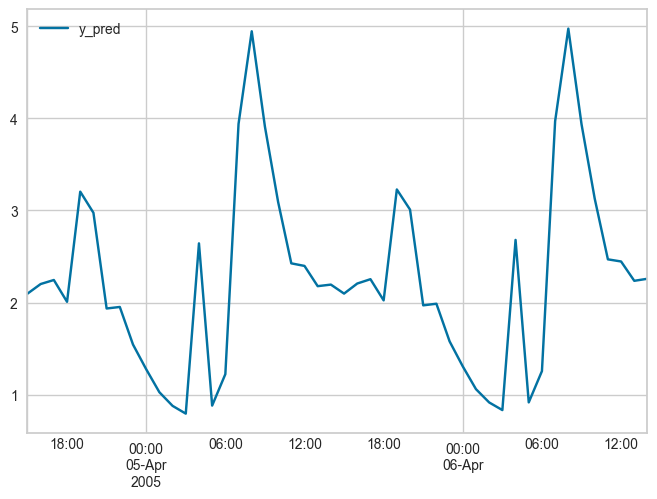

In [46]:
# 예측
future_preds = exp_future.predict_model(
    final_slim_model,  # 모델 입력
    X=future_exog,  # 외생변수 입력
)

# 결과 시각화
future_preds.plot()

이제 우리의 데이터셋을 수동으로 모델링하는 과정을 자동화하여 재현해 보겠습니다.


## 📍 (전체 자동화) AutoML을 사용한 자동화된 시계열 모델링


### 1️⃣ 데이터 전처리


In [47]:
# 데이터 로드
data = get_data("airquality", verbose=False)

# 간단한 데이터 전처리 (demo 용)
# 추후 더 정확한 예측을 위하여 정교한 전처리가 요구될 수 있습니다.
data = data.iloc[-720:]
data.insert(0, "datetime", pd.to_datetime(data["Date"] + " " + data["Time"]))
data.drop(columns=["Date", "Time"], inplace=True)
data.replace(-200, np.nan, inplace=True)
data.set_index("datetime", inplace=True)

# 타겟 정의
target = "CO(GT)"
# 사용할 외생변수 정의
exog_vars = ["NOx(GT)", "PT08.S3(NOx)", "RH"]

# 최종 사용 Feature 정의
include = [target] + exog_vars
data = data[include]
data.head()

,CO(GT),NOx(GT),PT08.S3(NOx),RH
datetime,,,,
2005-03-05 15:00:00,1.5,180.0,820.0,28.3
2005-03-05 16:00:00,1.8,255.0,751.0,29.7
2005-03-05 17:00:00,2.0,251.0,721.0,38.7
2005-03-05 18:00:00,1.9,258.0,695.0,56.3
2005-03-05 19:00:00,2.5,344.0,654.0,57.9


### 2️⃣ 하이퍼 파라미터 정의


In [48]:
FH = 48  # 예측 Forecasting Horizon
metric = "mase"  # 평가지표

# 예측에 제외할 모델명 입력
exclude_models = [
    "auto_arima",
    "bats",
    "tbats",
    "lar_cds_dt",
    "par_cds_dt",
]

### 3️⃣ 모델 생성


In [49]:
exp_auto = TSForecastingExperiment()

exp_auto.setup(
    data=data,
    target=target,
    fh=FH,
    # enforce_exogenous=False --> 모델이 지원하는 경우 다변량 예측을 사용하고, 그렇지 않은 경우 단일 변수 예측을 사용합니다.
    enforce_exogenous=False,
    numeric_imputation_target="drift",
    numeric_imputation_exogenous="linear",
    fig_kwargs=global_fig_settings,
    session_id=42,
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(720, 4)"
5,Transformed data shape,"(720, 4)"
6,Transformed train set shape,"(672, 4)"
7,Transformed test set shape,"(48, 4)"
8,Rows with missing values,3.8%
9,Fold Generator,ExpandingWindowSplitter


In [50]:
# 사용 가능한 모델 확인하기
exp_auto.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend.PolynomialTrendForeca...,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
exp_smooth,Exponential Smoothing,sktime.forecasting.exp_smoothing.ExponentialSm...,True
ets,ETS,sktime.forecasting.ets.AutoETS,True
theta,Theta Forecaster,sktime.forecasting.theta.ThetaForecaster,True


In [51]:
# Prophet과 같은 느린 모델을 포함(turbo=False) 하되, 특정 모델을 제외합니다.
best = exp_auto.compare_models(sort=metric, turbo=False, exclude=exclude_models)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.2887,0.3406,0.2167,0.3690,0.2012,0.1809,0.7031,0.4167
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8021,0.7953,0.6025,0.8618,0.4299,0.3924,-0.7004,0.2267
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8061,0.7971,0.6055,0.8638,0.4334,0.4000,-0.7038,0.2300
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.8064,0.7973,0.6057,0.8640,0.4337,0.4004,-0.7041,0.2333
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.9400,0.8940,0.7055,0.9686,0.5424,0.4850,-1.1793,0.2367
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.9624,0.9278,0.7233,1.0050,0.5227,0.3703,-1.6815,0.2533
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.9693,0.9331,0.7284,1.0107,0.5267,0.3722,-1.7354,0.2267
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.9693,0.9331,0.7284,1.0107,0.5267,0.3722,-1.7355,0.2267
theta,Theta Forecaster,0.9707,0.8809,0.7316,0.9578,0.4972,0.4405,-0.2475,0.0267
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.9752,0.9343,0.7327,1.0119,0.5327,0.3746,-1.7656,0.2267


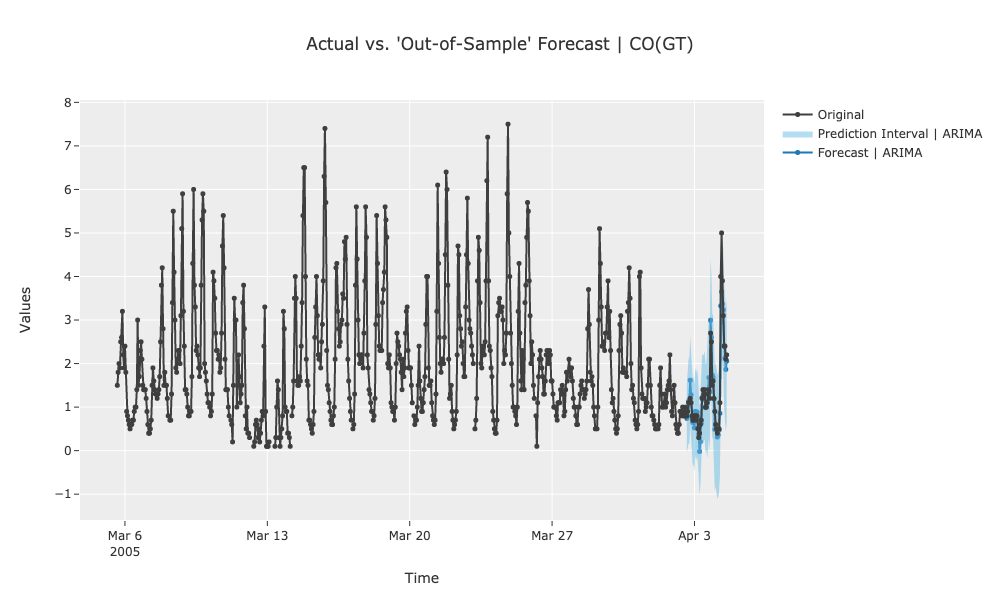

In [52]:
# best 모델로 시각화
exp_auto.plot_model(best)

In [53]:
# 전체 데이터셋으로 재학습
final_auto_model = exp_auto.finalize_model(best)

### 4️⃣ 최종 예측


In [54]:
def safe_predict(exp, model):
    """예측용 wrapper 함수."""
    try:
        future_preds = exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(f"미래 예측을 위해 {len(exo_vars)}개의 외생 변수 (X)가 필요합니다:\n{exo_vars}")

        exog_exps = []
        exog_models = []
        for exog_var in exog_vars:
            exog_exp = TSForecastingExperiment()
            exog_exp.setup(
                data=data[exog_var],
                fh=FH,
                numeric_imputation_target="drift",
                numeric_imputation_exogenous="linear",
                fig_kwargs=global_fig_settings,
                session_id=42,
                verbose=False,
            )

            # 사용자는 미래 외생 변수를 모델링하는 방법을 사용자 정의할 수 있습니다.
            # 예를 들어, 더 많은 단계와 모델을 추가하여 더 나은 모델을 얻을 수 있지만,
            # 모델링 시간이 늘어날 수 있습니다.
            best = exog_exp.compare_models(
                sort=metric,
                include=[
                    "arima",
                    "ets",
                    "exp_smooth",
                    "theta",
                    "lightgbm_cds_dt",
                ],
                verbose=False,
            )
            final_exog_model = exog_exp.finalize_model(best)

            exog_exps.append(exog_exp)
            exog_models.append(final_exog_model)

        # 단계 2: 외생 변수에 대한 미래 예측 얻기 ----
        future_exog = [
            exog_exp.predict_model(exog_model)
            for exog_exp, exog_model in zip(exog_exps, exog_models)
        ]
        future_exog = pd.concat(future_exog, axis=1)
        future_exog.columns = exog_vars

        future_preds = exp.predict_model(model, X=future_exog)

    return future_preds

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
미래 예측을 위해 3개의 외생 변수 (X)가 필요합니다:
['NOx(GT)', 'PT08.S3(NOx)', 'RH']


<Axes: >

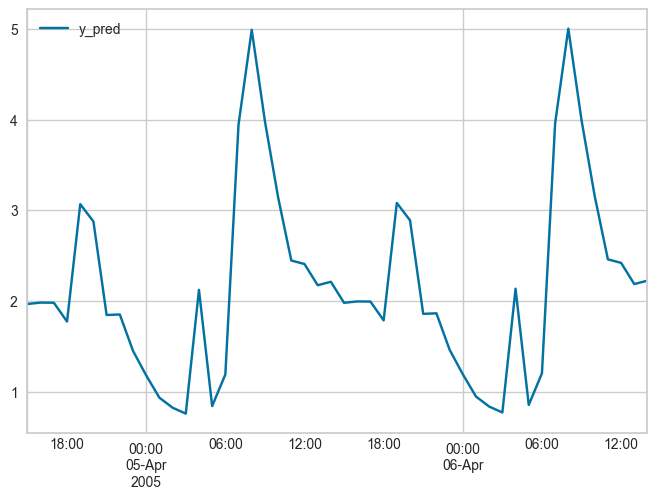

In [55]:
future_preds = safe_predict(exp_auto, final_auto_model)
future_preds.plot()